# (참고) Many-to-Many 

https://github.com/CaptainE/RNN-LSTM-in-numpy/blob/master/RNN_LSTM_from_scratch.ipynb

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$

### Using Full-gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

#### Sigmoid activation

In [2]:
def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

#### Hyperbolic Tangent activation

In [3]:
def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

#### Softmax

In [4]:
def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

### Define Embeddings

In [5]:
idx2char = [ _ for _ in 'MATH']
print(len(idx2char))
idx2char

4


['M', 'A', 'T', 'H']

In [6]:
x_data = [[0,1,2]] # MAT
y_data = [[1,2,3]]  # ATH

In [7]:
input = tf.keras.utils.to_categorical(x_data, num_classes=len(idx2char))
input = np.squeeze(input)
input

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [8]:
output = tf.keras.utils.to_categorical(y_data, num_classes=len(idx2char))
output = np.squeeze(output)
output

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [9]:
np.size(input, 0)

3

In [10]:
N = np.size(input,0) # number of samples
Ni = np.size(input,1) # dimension of the samples of input
No = np.size(output,1) # dimension of the sample of output
Nh = 20 # number of hidden units

print('number of samples :', N)
print('dimension of the samples of input :', Ni)
print('dimension of the sample of outputs :', No)
print('number of hidden units :', Nh)

number of samples : 3
dimension of the samples of input : 4
dimension of the sample of outputs : 4
number of hidden units : 20


(0 epoch) LOSS : 1.5105639399861133
(100 epoch) LOSS : 1.494077816616058
(200 epoch) LOSS : 1.4766619838052086
(300 epoch) LOSS : 1.458860939003921
(400 epoch) LOSS : 1.4402753955495373
(500 epoch) LOSS : 1.4205005592567632
(600 epoch) LOSS : 1.3991160319098572
(700 epoch) LOSS : 1.375670179314577
(800 epoch) LOSS : 1.3496544874747258
(900 epoch) LOSS : 1.3204620750210754
(1000 epoch) LOSS : 1.2873279375209405
(1100 epoch) LOSS : 1.2492726446132625
(1200 epoch) LOSS : 1.2051735551971048
(1300 epoch) LOSS : 1.1544369234726646
(1400 epoch) LOSS : 1.0994410532100831
(1500 epoch) LOSS : 1.049358968415837
(1600 epoch) LOSS : 1.0149389635183919
(1700 epoch) LOSS : 0.9941858733031297
(1800 epoch) LOSS : 0.9794918940502386
(1900 epoch) LOSS : 0.9678639659935747


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


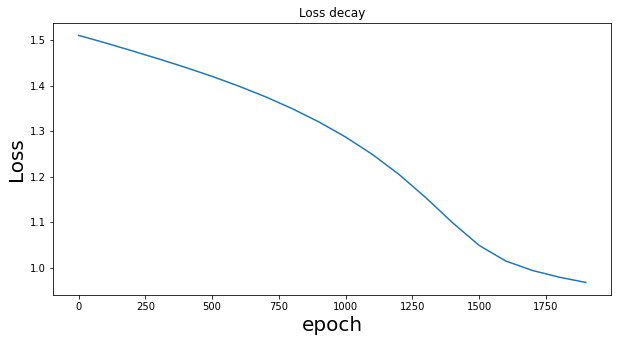

In [13]:
# learning rate
lr_rate = 0.003

# x->h
U = 2/np.sqrt(Nh)*(np.random.rand(Nh,Ni) - 0.5) # Xavier initialization

# prev_h->next_h
V = 2/np.sqrt(Nh)*(np.random.rand(Nh,Nh) - 0.5) # Xavier initialization

# h->o
W = 2/np.sqrt(Nh)*(np.random.rand(No,Nh) - 0.5) # Xavier initialization

# init epoch, history
t_ = []
loss_ = []

## TRAIN
hidden = np.zeros(Nh)

for epoch in range(0,2000):
    loss = 0
    
    for id_ in range(0,N):
        # Forward
        dU = 0*U
        dW = 0*W
        dV = 0*V
        
        # get x
        x = input[id_]
        S = np.dot(U,x)
        H = np.dot(V, hidden)
        
        # update hidden
        hidden = tanh(S) + H
        
        # get output
        y = sigmoid(np.dot(W, hidden))
        d = output[id_]
        
        # Backward
        # Update W
        for j in range(0,Nh):
            for i in range(0,No):
                # (y[i]*(1-y[i]))는 첫번째 sigmoid의 미분값
                dW[i,j] = dW[i,j] + (tanh(S[j])+ H[j])*(y[i]*(1-y[i]))*(y[i]-d[i])
                
        W = W - lr_rate*dW
        
        # Update V
        for k in range(0,Nh):
            for j in range(0,Nh):
                for i in range(0,No):
                    dV[j,k] = dV[j,k] + W[i,j] * hidden[k] * (y[i]*(1-y[i])) * (y[i]-d[i])
        
        V = V - lr_rate*dV

        # Update U
        for k in range(0,Ni):
            for j in range(0,Nh):
                for i in range(0,No):
                    # (1-tanh(S[j])**2)는 tanh의 미분값
                    dU[j,k] = dU[j,k] + W[i,j] * x[k] * (1-tanh(S[j])**2) * (y[i]*(1-y[i])) * (y[i]-d[i]) 
        
        U = U - lr_rate*dU
        
        loss = loss + 1/2*np.linalg.norm(y-d)
        
    if np.mod(epoch,100) == 0:
        t_ = np.append(t_,epoch)
        loss_ = np.append(loss_,loss)
        print("(", epoch, " epoch) LOSS : ", loss, sep = '')
        
plt.figure(num=0,figsize=[10,5])
plt.plot(t_,loss_,marker="")
plt.title('Loss decay')
plt.xlabel('epoch',FontSize=20)
plt.ylabel('Loss',FontSize=20)
plt.show()

In [18]:
## TEST
hidden = np.zeros(Nh)

for id_ in range(0,N):
    pred = [0,0,0,0]
    
    x = input[id_]
    S = np.dot(U,x)
    H = np.dot(V, hidden)
        
    # update hidden
    hidden = tanh(S) + H

    # get output
    y = sigmoid(np.dot(W, hidden))
    
    pred[np.argmax(y)]=1
    print(pred, "/", idx2char[np.argmax(y)])

[0, 1, 0, 0] / A
[0, 0, 1, 0] / T
[0, 0, 0, 1] / H


---

### Using Delta Rule

- input : `MAT` -> output : `H`

In [20]:
indx2char = [_ for _ in 'MATH']
print(indx2char)

M=[1,0,0,0]; A=[0,1,0,0]; T=[0,0,1,0]; H=[0,0,0,1];

input = [M, A, T]
output = [A, T, H]

['M', 'A', 'T', 'H']


In [21]:
input

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]

In [22]:
output

[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

In [23]:
N = np.size(input,0) # number of samples
Ni = np.size(input,1) # dimension of the samples of input
No = np.size(output,1) # dimension of the sample of output
Nh = 20 # number of hidden units

print('number of samples :', N)
print('dimension of the samples of input :', Ni)
print('dimension of the sample of outputs :', No)
print('number of hidden units :', Nh)

number of samples : 3
dimension of the samples of input : 4
dimension of the sample of outputs : 4
number of hidden units : 20


0 th epoch trained 	| 1.5266847001249944
50 th epoch trained 	| 1.4593835434213664
100 th epoch trained 	| 1.394617830200013
150 th epoch trained 	| 1.3326869325065807
200 th epoch trained 	| 1.2738018971540517
250 th epoch trained 	| 1.218086190026328
300 th epoch trained 	| 1.16558289153304
350 th epoch trained 	| 1.116266388048653
400 th epoch trained 	| 1.070056300272467
450 th epoch trained 	| 1.0268316610426322
500 th epoch trained 	| 0.986443928748518
550 th epoch trained 	| 0.9487280443712971
600 th epoch trained 	| 0.9135112538725791
650 th epoch trained 	| 0.8806197665513278
700 th epoch trained 	| 0.8498835135952293
750 th epoch trained 	| 0.8211393479916634
800 th epoch trained 	| 0.7942330298657956
850 th epoch trained 	| 0.7690203048390085
900 th epoch trained 	| 0.7453673308072526
950 th epoch trained 	| 0.7231506546380032
1000 th epoch trained 	| 0.7022568917594385
1050 th epoch trained 	| 0.6825822211968702
1100 th epoch trained 	| 0.6640317766072362
1150 th epoch trai

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


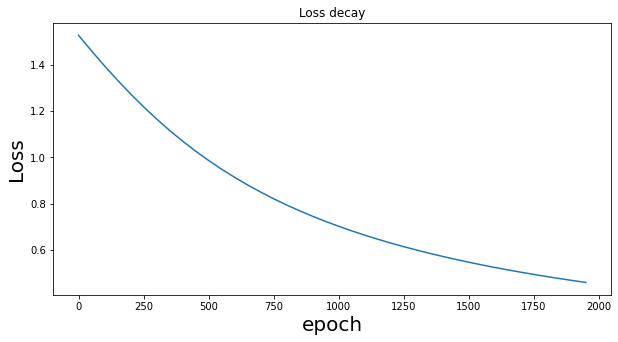

======================= FINISH =========================


In [26]:
# learning rate
lr_rate = 0.003

U = 2/np.sqrt(Nh)*(np.random.rand(Nh,Ni) - 0.5) # Xavier initialization
V = 2/np.sqrt(Nh)*(np.random.rand(Nh,Nh) - 0.5) # Xavier initialization
W = 2/np.sqrt(Nh)*(np.random.rand(No,Nh) - 0.5) # Xavier initialization

# init epoch, history
t_ = []
loss_ = []

## TRAIN
hidden = np.zeros(Nh)

for epoch in range(0,2000):
    loss = 0
    h = []
    
    for id_ in range(0,N):   # Forward pass
        
        x = input[id_]
        
        v1 = np.dot(U,x) + np.dot(V,hidden)
            
        y1 = sigmoid(v1)
        if id_ != N-1:
            hidden = y1
        else:
            hidden = 0*y1
        h.append(y1)
       
        if id_ == N-1:
            v2 = np.dot(W,y1)
            y2 = sigmoid(v2)
            d = output[id_]

    
    for id__ in range(0,N):   # Backward pass
        id_ = N-1 - id__

        # delta rule
        if id_ == N-1:
            e = y2 - d
            delta = y2*(1-y2)*e
        
            e1 = np.dot(np.transpose(W),delta)
            delta1 = y1*(1-y1)*e1
        
            x = input[id_]
            W = W - lr_rate*np.dot(np.transpose([delta]),[y1])
            U = U - lr_rate*np.dot(np.transpose([delta1]),[x])
            V = V - lr_rate*np.dot(np.transpose([delta1]),[h[id_-1]])
                
            loss = loss + 1/2*np.linalg.norm(e)
            
        elif id_ == N-2:
            e2 = np.dot(np.transpose(V),delta1)
            y1 = h[id_]
            delta2 = y1*(1-y1)*e2
            
            x = input[id_]
            U = U - lr_rate*np.dot(np.transpose([delta2]),[x])
            V = V - lr_rate*np.dot(np.transpose([delta2]),[h[id_-1]])

            loss = loss + 1/2*np.linalg.norm(e)

        elif id_ == N-3:
            e3 = np.dot(np.transpose(V),delta2)
            y1 = h[id_]
            delta3 = y1*(1-y1)*e3
            
            x = input[id_]
            U = U - lr_rate*np.dot(np.transpose([delta3]),[x])
            V = V - lr_rate*np.dot(np.transpose([delta3]),[h[id_-1]])
            
            loss = loss + 1/2*np.linalg.norm(e)
            
        elif id_ == N-4:
            e4 = np.dot(np.transpose(V),delta3)
            y1 = h[id_]
            delta4 = y1*(1-y1)*e4
            
            x = input[id_]
            U = U - lr_rate*np.dot(np.transpose([delta4]),[x])
            V = V - lr_rate*np.dot(np.transpose([delta4]),[h[id_-1]])
            
            loss = loss + 1/2*np.linalg.norm(e)

        
    if np.mod(epoch,50) == 0:
        print(epoch,"th epoch trained \t|", loss)
            
        t_ = np.append(t_,epoch)
        loss_ = np.append(loss_,loss)


plt.figure(num=0,figsize=[10,5])
plt.plot(t_,loss_,marker="")
plt.title('Loss decay')
plt.xlabel('epoch',FontSize=20)
plt.ylabel('Loss',FontSize=20)
plt.show()
print('======================= FINISH =========================')

In [28]:
for id_ in range(0,N):
    x = input[id_]
        
    v1 = np.dot(U,x) + np.dot(V,hidden)
            
    y1 = sigmoid(v1)

    hidden = y1
       
    if id_ == N-1:
        v2 = np.dot(W,y1)
        y2 = sigmoid(v2)

        print(y2)
        print(indx2char[np.argmax(y2)])

[0.15935671 0.15481156 0.14811805 0.86033927]
H
